In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import warnings 
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import itertools
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from joblib import Parallel, delayed

In [2]:
df = pd.read_csv(r"data\model_input.csv")
dataset = df.drop(columns=["Unnamed: 0", "Min Temp", "Max Temp", "percentile_25", "percentile_75"])
dataset

,Mean Temp,RAINFALL,month_year,median
0,22.178833,0.085958,2013-04,0.455720
1,26.819516,0.413366,2013-05,0.665620
2,25.359833,31.586529,2013-06,0.226039
3,25.052258,20.653476,2013-07,0.249820
4,24.369032,24.446940,2013-08,0.267682
...,...,...,...,...
112,25.292838,13.266669,2022-08,0.238900
113,23.823002,11.473897,2022-09,0.244405
114,20.420344,3.875470,2022-10,0.419238
115,16.548313,0.000000,2022-11,0.518314


In [3]:
dataset['month_year'] = pd.to_datetime(dataset['month_year'])
dataset['year'] = dataset['month_year'].dt.year
dataset['month'] = dataset['month_year'].dt.month
ts_dataset = dataset.drop(columns=["month_year"])
ts_dataset

,Mean Temp,RAINFALL,median,year,month
0,22.178833,0.085958,0.455720,2013,4
1,26.819516,0.413366,0.665620,2013,5
2,25.359833,31.586529,0.226039,2013,6
3,25.052258,20.653476,0.249820,2013,7
4,24.369032,24.446940,0.267682,2013,8
...,...,...,...,...,...
112,25.292838,13.266669,0.238900,2022,8
113,23.823002,11.473897,0.244405,2022,9
114,20.420344,3.875470,0.419238,2022,10
115,16.548313,0.000000,0.518314,2022,11


In [4]:
ts_dataset['timeindex'] = (ts_dataset['year'] - 2013)*12 + ts_dataset['month'] - 3
ts_dataset.drop(columns = ['year', 'month'], inplace=True)

In [5]:
median = ts_dataset['median']
ts_dataset.drop(columns='median', inplace=True)
ts_dataset['Median NDSI'] = median
ts_dataset

,Mean Temp,RAINFALL,timeindex,Median NDSI
0,22.178833,0.085958,1,0.455720
1,26.819516,0.413366,2,0.665620
2,25.359833,31.586529,3,0.226039
3,25.052258,20.653476,4,0.249820
4,24.369032,24.446940,5,0.267682
...,...,...,...,...
112,25.292838,13.266669,113,0.238900
113,23.823002,11.473897,114,0.244405
114,20.420344,3.875470,115,0.419238
115,16.548313,0.000000,116,0.518314


In [6]:
arima_dataset = ts_dataset.drop(columns=["Mean Temp", "RAINFALL"])
arima_dataset

,timeindex,Median NDSI
0,1,0.455720
1,2,0.665620
2,3,0.226039
3,4,0.249820
4,5,0.267682
...,...,...
112,113,0.238900
113,114,0.244405
114,115,0.419238
115,116,0.518314


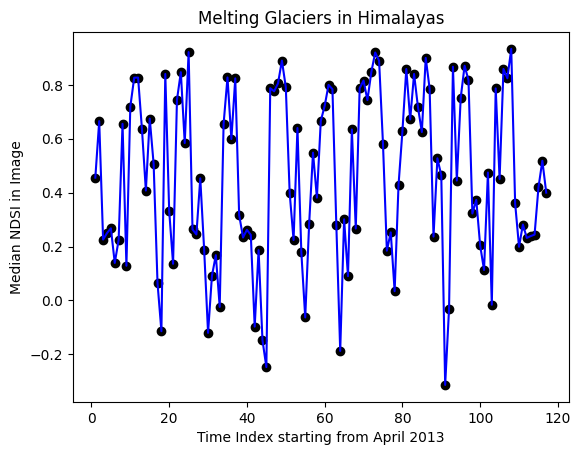

In [7]:
x = arima_dataset['timeindex']
y= arima_dataset['Median NDSI']
plt.plot(x, y, c = 'blue')
plt.scatter(x, y, c = 'black')
plt.xlabel("Time Index starting from April 2013")
plt.ylabel("Median NDSI in Image")
plt.title("Melting Glaciers in Himalayas")
plt.show()

In [8]:
result1 = adfuller(arima_dataset['Median NDSI'])
result1
# If p-value > 0.05, the series is not stationary

(-1.845308580329862,
 0.3582103719315229,
 11,
 105,
 {'1%': -3.4942202045135513,
  '5%': -2.889485291005291,
  '10%': -2.5816762131519275},
 14.097917048274866)

In [9]:
result2 = sm.tsa.stattools.kpss(arima_dataset['Median NDSI'], regression='ct')
result2
# If p-value < 0.05, the series is not stationary

C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_22068\2406077758.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result2 = sm.tsa.stattools.kpss(arima_dataset['Median NDSI'], regression='ct')


(0.04316002196408604,
 0.1,
 4,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

<Axes: >

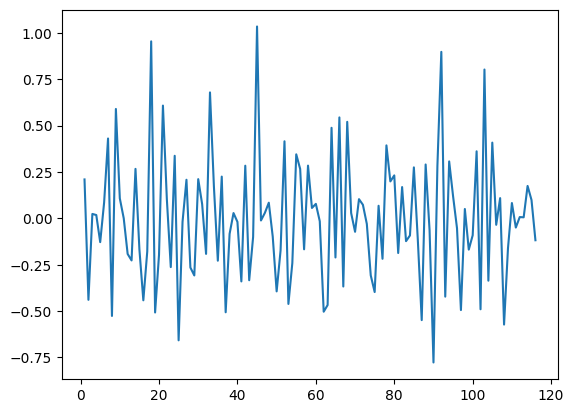

In [10]:
diff1 = arima_dataset['Median NDSI'].diff().dropna()
diff1.plot()

In [11]:
result3 = adfuller(diff1)
result3

(-6.732153242922841,
 3.2753347414858138e-09,
 12,
 103,
 {'1%': -3.4954932834550623,
  '5%': -2.8900369024285117,
  '10%': -2.5819706975209726},
 13.795287687547471)

In [12]:
train = arima_dataset[:-11]
test = arima_dataset[-11:]

In [13]:
# p = q = range(0, 13)
# d = [1,2]

# # Generate all different combinations of p, d, q triplets
# pdq = list(itertools.product(p, d, q))

# rmse = []
# params = []

# for param in tqdm.tqdm(pdq, desc="Grid Search for ARIMA"):
#     try:
#         model = ARIMA(train['Median NDSI'], order=param)
#         model_fit = model.fit()
#         model_pred = model_fit.predict(start=len(train), end=(len(df) - 1))
#         error = np.sqrt(mse(test['Median NDSI'], model_pred))
#         params.append(param)
#         rmse.append(error)

#     except Exception as e:
#         pass

# results = pd.DataFrame(index=params, data=rmse, columns=['RMSE'])

# results = results.sort_values(by='RMSE')

In [14]:
# results

In [15]:
arima_model = auto_arima(
    train['Median NDSI'],
    start_p=0,  # Minimum value for p
    start_q=0,  # Minimum value for q
    max_p=12,    # Maximum value for p
    max_q=12,    # Maximum value for q
    d=None,     # Automatically detect the differencing order
    seasonal=False,  # Turn off seasonal ARIMA
    stepwise=True,   # Use stepwise search to find the best model
    trace=True,      # Enable trace for details of iterations
    error_action='ignore',  # Ignore non-fatal errors
    suppress_warnings=True, # Suppress warnings
    information_criterion='aic'  # Use AIC to select the best model
)

print(arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=180.114, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=75.056, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=123.678, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=70.884, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=69.136, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=69.430, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=70.442, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=71.341, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=52.641, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=50.664, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48.725, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=64.860, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=50.665, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=50.961, Time=0.03 se

In [24]:
error1 = []
error2 = []
error3 = []
test_split = []

def run_arima(y, test_percent):
    num = int(test_percent*len(y)/100)
    train = y[:-num]
    test = y[-num:]
    model = ARIMA(train, order=(12,2,0))
    model_fit = model.fit()
    model_pred = model_fit.predict(start = len(train), end = len(y)-1)
    rmse = np.sqrt(mse(test, model_pred))
    test_split.append(test_percent)
    error1.append(rmse)
    r2_train = r2_score(train, model_fit.predict(start = 0, end = len(train)-1))
    r2_test = r2_score(test, model_pred)
    error2.append(r2_train)
    error3.append(r2_test)
    
    print("RMSE = ", rmse)
    print("R2 Train = ", r2_train)
    print("R2 Test = ", r2_test)

    plt.plot(y.index, y, c = 'orange')
    plt.plot(y.index, model_fit.predict(start=0,end=len(y)-1), c = 'cyan')
    plt.scatter(y.index, y, c = 'black')
    plt.scatter(y.index, model_fit.predict(start=0,end=len(y)-1), c = 'brown')
    plt.xlabel("Time")
    plt.ylabel("Median NDSI of Image")
    plt.title("Actual vs Prediction ARIMA")
    plt.legend(["Actual", "Prediction"])
    plt.show()    

RMSE =  0.23035502435550442
R2 Train =  0.14415518920543502
R2 Test =  0.03917146860081666


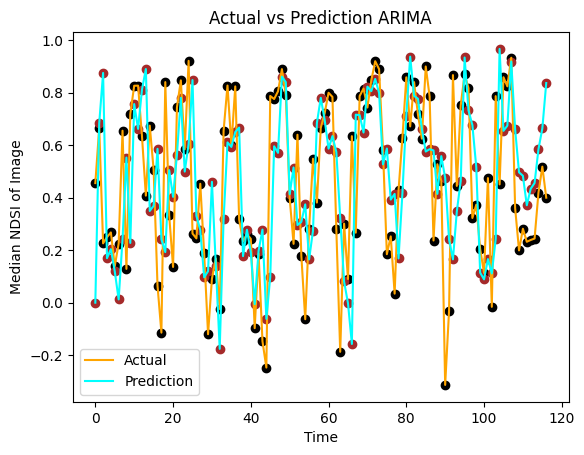

RMSE =  0.3169179236287131
R2 Train =  0.17233097874554393
R2 Test =  -0.35139649757407065


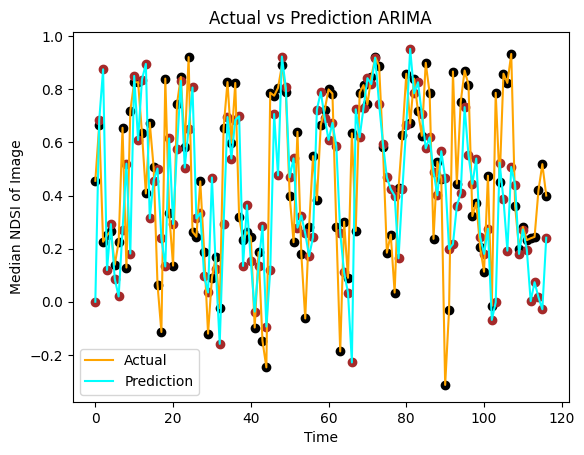

RMSE =  0.2605882917978978
R2 Train =  0.19129323085165606
R2 Test =  0.2789672867238736


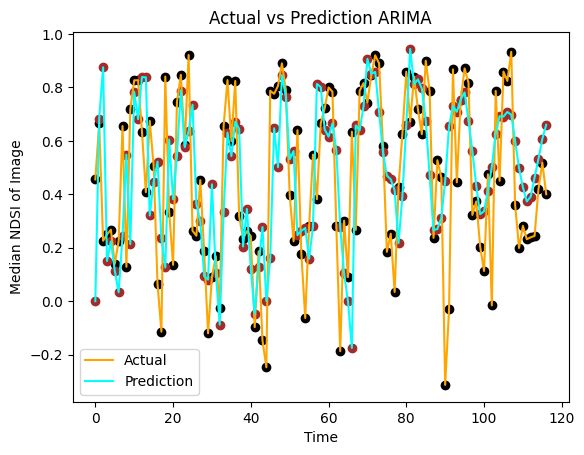

RMSE =  0.5160479031433169
R2 Train =  0.14333519068796607
R2 Test =  -1.8315844612339207


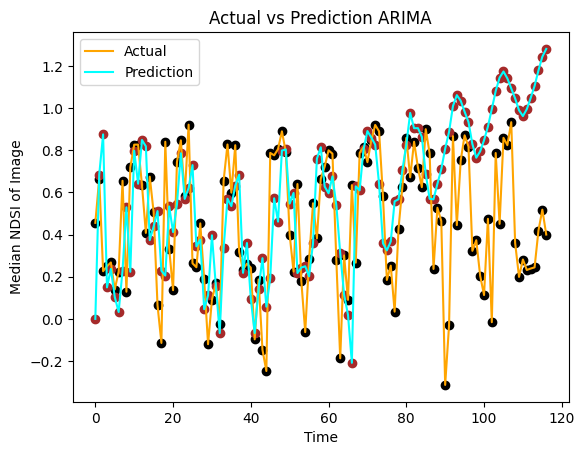

RMSE =  0.4414952187650623
R2 Train =  0.19340645153321268
R2 Test =  -1.022959552750625


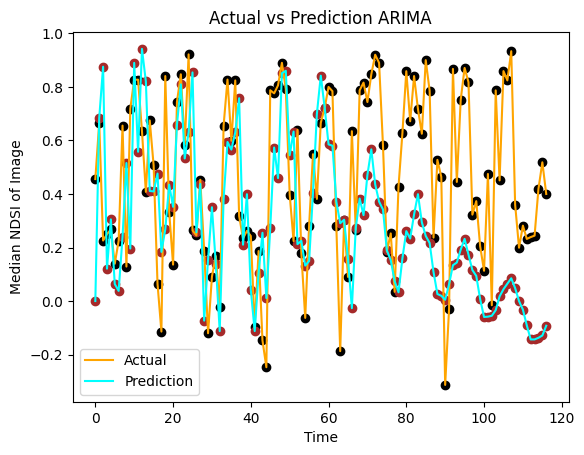

RMSE =  0.29682666178423245
R2 Train =  0.22496233537100807
R2 Test =  0.05651702747391352


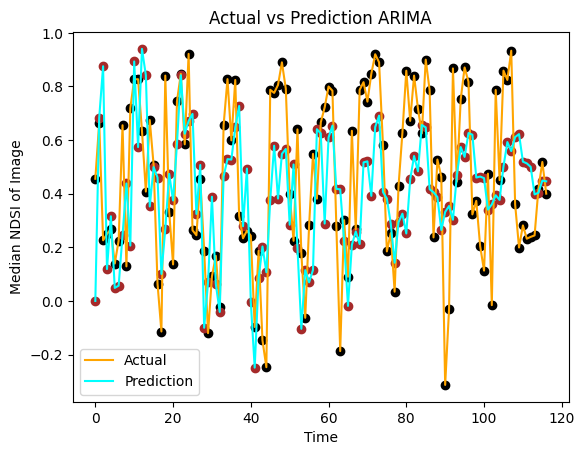

RMSE =  0.7429539061075802
R2 Train =  0.23686584012593837
R2 Test =  -4.335430977121823


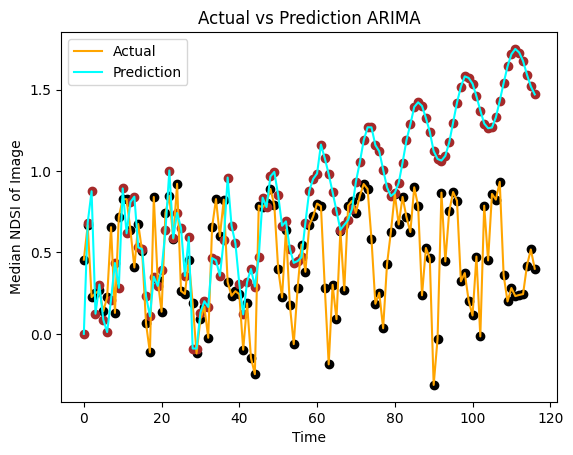

RMSE =  0.9954982124903271
R2 Train =  0.0902358947585592
R2 Test =  -8.463410840465007


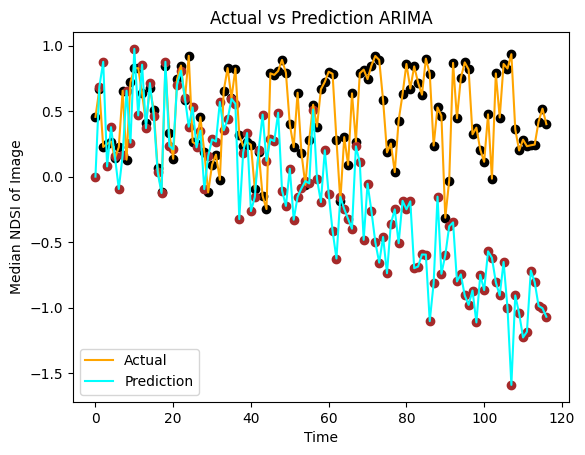

In [25]:
for i in range(10,90,10):
    run_arima(y, i)

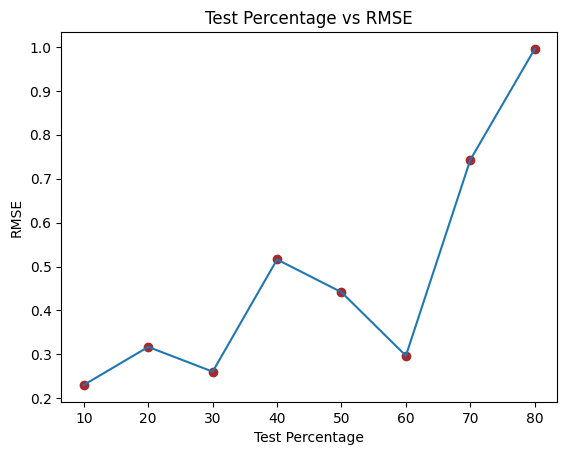

In [ ]:
plt.plot(test_split,error1)
plt.scatter(test_split,error1, c='brown')
plt.xlabel("Test Percentage")
plt.ylabel("RMSE")
plt.title("Test Percentage vs RMSE")
plt.show()    